In [33]:
import os
import pandas as pd
import re
import numpy as np
from datetime import datetime
import csv

def process_intensity_files(root_dir="intensityData"):
    """
    Process all Fitbit intensity files in the given directory structure and create a dataframe.

    Args:
        root_dir (str): Root directory containing subject folders

    Returns:
        pd.DataFrame: DataFrame with columns: subject_id, day, intensity_array
    """
    results = []

    # Walk through the directory structure
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if "_minuteIntensitiesNarrow_" in filename and filename.endswith(".csv"):
                file_path = os.path.join(dirpath, filename)
                match = re.search(r'CaM(\d+)-(\d+)', file_path)
                if match:
                    subject_id = int(match.group(2))
                    subject_data = process_file(file_path, subject_id)
                    results.extend(subject_data)

    df = pd.DataFrame(results, columns=['subject_id', 'day', 'intensity_array'])
    df['subject_id'] = df['subject_id'].astype(int)
    return df


def main():
    df = process_intensity_files()
    print(f"Generated DataFrame with {len(df)} rows.")
    print("\nDataFrame Sample:")
    print(df.head())

    print("\nFiltering example - Subject ID 1:")
    subject_1_data = df[df['subject_id'] == 1]
    print(f"Found {len(subject_1_data)} rows for subject ID 1")
    if not subject_1_data.empty:
        print(subject_1_data.head())

    # Uncomment below to save
    # df.to_csv('fitbit_intensity_data.csv', index=False)
    # print("\nDataFrame saved to 'fitbit_intensity_data.csv'")

    return df


if __name__ == "__main__":
    df = main()


/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_2844/3165010316.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_2844/3165010316.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_2844/3165010316.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
/var/folders/

Generated DataFrame with 486 rows.

DataFrame Sample:
   subject_id         day                                    intensity_array
0           5  2021-12-06  [0, 0, 0, 0, 0, 0, 2, 12, 21, 10, 10, 8, 17, 1...
1           5  2021-12-07  [0, 2, 0, 0, 0, 0, 0, 0, 15, 25, 8, 11, 6, 43,...
2           5  2021-12-08  [2, 10, 0, 0, 0, 0, 0, 7, 17, 42, 95, 165, 71,...
3           5  2021-12-09  [7, 3, 0, 0, 0, 0, 0, 0, 7, 20, 24, 6, 32, 132...
4           5  2021-12-10  [2, 7, 0, 0, 0, 0, 0, 6, 8, 16, 31, 155, 133, ...

Filtering example - Subject ID 1:
Found 11 rows for subject ID 1
     subject_id         day                                    intensity_array
251           1  2021-09-18  [0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 1, 21, 14, 26,...
252           1  2021-09-19  [40, 19, 1, 1, 1, 0, 0, 0, 32, 21, 170, 73, 19...
253           1  2021-09-20  [26, 0, 0, 0, 0, 0, 1, 60, 33, 34, 16, 19, 9, ...
254           1  2021-09-21  [1, 0, 9, 1, 0, 0, 1, 21, 39, 15, 7, 18, 20, 4...
255           1  2021-0

In [32]:
def process_file(file_path, subject_id):
    """
    Process a single intensity file and extract daily intensity arrays (hourly resolution).
    
    Handles both hourly and minute-level data.
    
    Returns:
        list of dicts: Each with subject_id, day (YYYY-MM-DD), and intensity_array (24-length list).
    """
    daily_intensities = {}

    try:
        df = pd.read_csv(file_path, encoding='utf-8-sig')

        # Detect timestamp and intensity column names
        time_col = next((col for col in df.columns if 'ActivityHour' in col or 'ActivityMinute' in col or 'Time' in col or 'Date' in col), None)
        intensity_col = next((col for col in df.columns if 'Intensity' in col), None)

        if time_col is None or intensity_col is None:
            print(f"Warning: Could not detect expected columns in {file_path}. Skipping.")
            return []

        # Parse timestamp
        df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
        df = df.dropna(subset=[time_col])
        df['day'] = df[time_col].dt.strftime('%Y-%m-%d')
        df['hour'] = df[time_col].dt.hour

        # Convert intensity to numeric
        df[intensity_col] = pd.to_numeric(df[intensity_col], errors='coerce').fillna(0).astype(int)

        # Group by day and hour
        grouped = df.groupby(['day', 'hour'])[intensity_col].sum().reset_index()

        # Build daily 24-element intensity arrays
        for day, group in grouped.groupby('day'):
            array = np.zeros(24, dtype=int)
            for _, row in group.iterrows():
                hour = int(row['hour'])
                array[hour] = row[intensity_col]
            daily_intensities[day] = array

    except Exception as e:
        print(f"Error processing file {file_path} for subject {subject_id}: {e}")
        return []

    # Format result
    results = []
    for day, intensity_array in daily_intensities.items():
        results.append({
            'subject_id': subject_id,
            'day': day,
            'intensity_array': intensity_array.tolist()
        })

    return results


In [34]:
df = main()

/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_2844/3165010316.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_2844/3165010316.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_2844/3165010316.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
/var/folders/

Generated DataFrame with 486 rows.

DataFrame Sample:
   subject_id         day                                    intensity_array
0           5  2021-12-06  [0, 0, 0, 0, 0, 0, 2, 12, 21, 10, 10, 8, 17, 1...
1           5  2021-12-07  [0, 2, 0, 0, 0, 0, 0, 0, 15, 25, 8, 11, 6, 43,...
2           5  2021-12-08  [2, 10, 0, 0, 0, 0, 0, 7, 17, 42, 95, 165, 71,...
3           5  2021-12-09  [7, 3, 0, 0, 0, 0, 0, 0, 7, 20, 24, 6, 32, 132...
4           5  2021-12-10  [2, 7, 0, 0, 0, 0, 0, 6, 8, 16, 31, 155, 133, ...

Filtering example - Subject ID 1:
Found 11 rows for subject ID 1
     subject_id         day                                    intensity_array
251           1  2021-09-18  [0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 1, 21, 14, 26,...
252           1  2021-09-19  [40, 19, 1, 1, 1, 0, 0, 0, 32, 21, 170, 73, 19...
253           1  2021-09-20  [26, 0, 0, 0, 0, 0, 1, 60, 33, 34, 16, 19, 9, ...
254           1  2021-09-21  [1, 0, 9, 1, 0, 0, 1, 21, 39, 15, 7, 18, 20, 4...
255           1  2021-0

In [35]:
df

,subject_id,day,intensity_array
0,5,2021-12-06,"[0, 0, 0, 0, 0, 0, 2, 12, 21, 10, 10, 8, 17, 1..."
1,5,2021-12-07,"[0, 2, 0, 0, 0, 0, 0, 0, 15, 25, 8, 11, 6, 43,..."
2,5,2021-12-08,"[2, 10, 0, 0, 0, 0, 0, 7, 17, 42, 95, 165, 71,..."
3,5,2021-12-09,"[7, 3, 0, 0, 0, 0, 0, 0, 7, 20, 24, 6, 32, 132..."
4,5,2021-12-10,"[2, 7, 0, 0, 0, 0, 0, 6, 8, 16, 31, 155, 133, ..."
...,...,...,...
481,23,2022-07-03,"[9, 1, 0, 0, 0, 0, 0, 0, 14, 23, 30, 29, 27, 9..."
482,23,2022-07-04,"[2, 0, 1, 0, 0, 0, 0, 20, 35, 73, 7, 2, 5, 2, ..."
483,23,2022-07-05,"[0, 0, 0, 0, 0, 0, 0, 24, 63, 45, 57, 68, 23, ..."
484,23,2022-07-06,"[0, 0, 0, 0, 0, 0, 2, 30, 56, 65, 74, 72, 59, ..."


In [36]:
day_counts = df.groupby('subject_id')['day'].count().reset_index()
day_counts.columns = ['subject_id', 'day_count']

In [37]:
subject_1_data = df[df['subject_id'] == 1]

# Display all rows for subject ID 1
print(f"Found {len(subject_1_data)} rows for subject ID 1")
print(subject_1_data)

Found 11 rows for subject ID 1
     subject_id         day                                    intensity_array
251           1  2021-09-18  [0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 1, 21, 14, 26,...
252           1  2021-09-19  [40, 19, 1, 1, 1, 0, 0, 0, 32, 21, 170, 73, 19...
253           1  2021-09-20  [26, 0, 0, 0, 0, 0, 1, 60, 33, 34, 16, 19, 9, ...
254           1  2021-09-21  [1, 0, 9, 1, 0, 0, 1, 21, 39, 15, 7, 18, 20, 4...
255           1  2021-09-22  [0, 3, 7, 0, 0, 0, 3, 62, 42, 16, 1, 12, 28, 1...
256           1  2021-09-23  [1, 3, 6, 0, 0, 0, 21, 14, 54, 28, 9, 17, 25, ...
257           1  2021-09-24  [15, 0, 1, 0, 0, 2, 10, 132, 44, 103, 41, 29, ...
258           1  2021-09-25  [1, 8, 5, 0, 0, 1, 1, 0, 1, 25, 95, 51, 15, 11...
259           1  2021-09-26  [0, 1, 0, 0, 0, 0, 1, 0, 6, 28, 61, 130, 125, ...
260           1  2021-09-27  [30, 12, 1, 0, 0, 0, 0, 18, 34, 12, 8, 4, 28, ...
261           1  2021-09-28  [9, 1, 0, 0, 0, 0, 6, 27, 39, 36, 46, 6, 9, 7,...


In [46]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_heatmap_no_legend(df, subject_id=None, save=True):
    # Filter for subject_id if provided
    if subject_id is not None:
        df = df[df['subject_id'] == subject_id]

    # Sort and convert day to datetime
    df = df.sort_values(by='day')
    df['day'] = pd.to_datetime(df['day'])

    # Convert intensity_array to 2D array
    intensity_matrix = np.array(df['intensity_array'].tolist())

    # Compute 5th and 95th percentiles for color scaling
    vmin = np.percentile(intensity_matrix, 5)
    vmax = np.percentile(intensity_matrix, 95)

    # Create figure without labels
    plt.figure(figsize=(14, 6))
    plt.imshow(intensity_matrix, aspect='auto', cmap='coolwarm', interpolation='nearest', vmin=vmin, vmax=vmax)

    # Remove all axes labels, ticks, and borders
    plt.axis('off')
    #plt.show()

    # Save the heatmap to the directory
    if save:
        output_dir = "Intensity HeatMaps"
        os.makedirs(output_dir, exist_ok=True)
        filename = f"subject_{subject_id}_heatmap.png" if subject_id else "heatmap.png"
        filepath = os.path.join(output_dir, filename)
        plt.savefig(filepath, bbox_inches='tight', pad_inches=0)
        print(f"Saved heatmap to {filepath}")

    plt.close()



In [41]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_heatmap(df, subject_id=None, save=True):
    # Filter for subject_id if provided
    if subject_id is not None:
        df = df[df['subject_id'] == subject_id]

    # Sort and convert day to datetime
    df = df.sort_values(by='day')
    df['day'] = pd.to_datetime(df['day'])

    # Convert intensity_array to 2D array
    intensity_matrix = np.array(df['intensity_array'].tolist())

    # Create figure
    plt.figure(figsize=(14, 6))
    plt.imshow(intensity_matrix, aspect='auto', cmap='coolwarm', interpolation='nearest')

    # X-axis: hour labels
    num_hours = intensity_matrix.shape[1]
    plt.xticks(ticks=np.arange(0, num_hours, 2), labels=[f'{h}:00' for h in range(0, num_hours, 2)])
    plt.xlabel('Hour of Day')

    # Y-axis: trial day numbers
    num_days = len(df)
    plt.yticks(ticks=np.arange(num_days), labels=[str(i + 1) for i in range(num_days)])
    plt.ylabel('Day of Trial')

    # Add colorbar and title
    plt.colorbar(label='Intensity')
    title = f'Intensity Heatmap for Subject {subject_id}' if subject_id else 'Intensity Heatmap'
    plt.title(title)
    plt.tight_layout()
    plt.show()

    # Save the heatmap to the directory
    if save:
        output_dir = "Intensity heat maps"
        os.makedirs(output_dir, exist_ok=True)
        filename = f"subject_{subject_id}_heatmap.png" if subject_id else "heatmap.png"
        filepath = os.path.join(output_dir, filename)
        plt.savefig(filepath)
        print(f"Saved heatmap to {filepath}")

    # Show the plot
    plt.close()  # Close to avoid displaying in loops or scripts


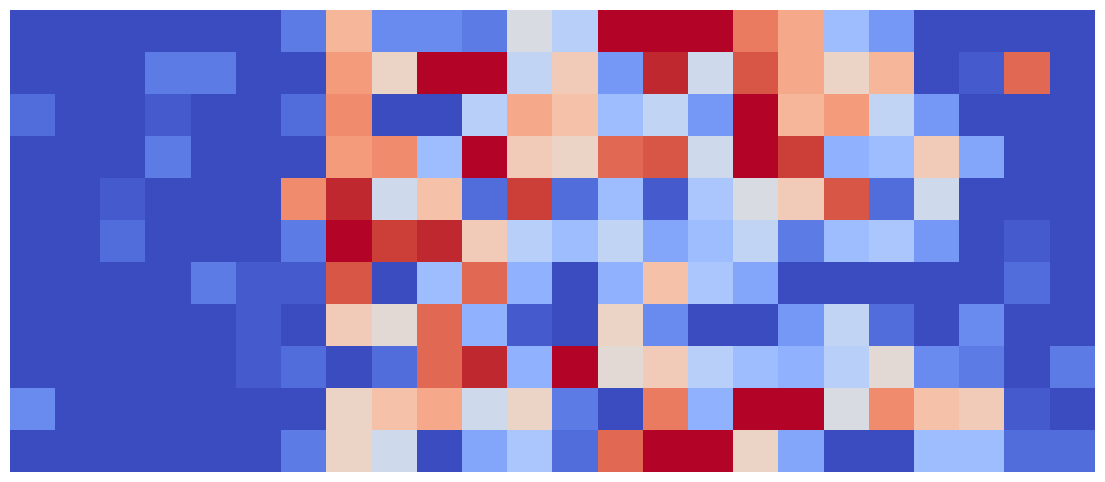

In [44]:
plot_heatmap_no_legend(df=df,subject_id=2,save=False)

In [47]:
for i in range(1, 50):
    try:
        plot_heatmap_no_legend(df=df,subject_id=i,save=True)
    except Exception as e:
        print(f"Error processing subject {i}: {e}. Skipping.")


Saved heatmap to Intensity HeatMaps/subject_1_heatmap.png
Saved heatmap to Intensity HeatMaps/subject_2_heatmap.png
Saved heatmap to Intensity HeatMaps/subject_3_heatmap.png
Saved heatmap to Intensity HeatMaps/subject_4_heatmap.png
Saved heatmap to Intensity HeatMaps/subject_5_heatmap.png
Saved heatmap to Intensity HeatMaps/subject_6_heatmap.png
Saved heatmap to Intensity HeatMaps/subject_7_heatmap.png
Saved heatmap to Intensity HeatMaps/subject_8_heatmap.png
Saved heatmap to Intensity HeatMaps/subject_9_heatmap.png
Saved heatmap to Intensity HeatMaps/subject_10_heatmap.png
Saved heatmap to Intensity HeatMaps/subject_11_heatmap.png
Saved heatmap to Intensity HeatMaps/subject_12_heatmap.png
Saved heatmap to Intensity HeatMaps/subject_13_heatmap.png
Saved heatmap to Intensity HeatMaps/subject_14_heatmap.png
Saved heatmap to Intensity HeatMaps/subject_15_heatmap.png
Saved heatmap to Intensity HeatMaps/subject_16_heatmap.png
Saved heatmap to Intensity HeatMaps/subject_17_heatmap.png
Saved 

In [24]:
# Filter the DataFrame for subject ID 1
subject_1_data = df[df['subject_id'] == 1]

# Display all rows for subject ID 1
print(f"Found {len(subject_1_data)} rows for subject ID 1")
print(subject_1_data)

Found 11 rows for subject ID 1
     subject_id         day                                    intensity_array
251           1  2021-09-18  [0, 0, 0, 0, 0, 0, 0, 0, 0, 18, 1, 21, 14, 26,...
252           1  2021-09-19  [40, 19, 1, 1, 1, 0, 0, 0, 32, 21, 170, 73, 19...
253           1  2021-09-20  [26, 0, 0, 0, 0, 0, 1, 60, 33, 34, 16, 19, 9, ...
254           1  2021-09-21  [1, 0, 9, 1, 0, 0, 1, 21, 39, 15, 7, 18, 20, 4...
255           1  2021-09-22  [0, 3, 7, 0, 0, 0, 3, 62, 42, 16, 1, 12, 28, 1...
256           1  2021-09-23  [1, 3, 6, 0, 0, 0, 21, 14, 54, 28, 9, 17, 25, ...
257           1  2021-09-24  [15, 0, 1, 0, 0, 2, 10, 132, 44, 103, 41, 29, ...
258           1  2021-09-25  [1, 8, 5, 0, 0, 1, 1, 0, 1, 25, 95, 51, 15, 11...
259           1  2021-09-26  [0, 1, 0, 0, 0, 0, 1, 0, 6, 28, 61, 130, 125, ...
260           1  2021-09-27  [30, 12, 1, 0, 0, 0, 0, 18, 34, 12, 8, 4, 28, ...
261           1  2021-09-28  [9, 1, 0, 0, 0, 0, 6, 27, 39, 36, 46, 6, 9, 7,...


In [39]:
    # Quick count of how many days per subject_id
    day_counts = df.groupby('subject_id')['day'].nunique().reset_index(name='day_count')
    print("\nNumber of unique days per subject_id:")
    print(day_counts)



Number of unique days per subject_id:
    subject_id  day_count
0            1         11
1            2         11
2            3         11
3            4         11
4            5         11
5            6         11
6            7         11
7            8         11
8            9         11
9           10         11
10          11         11
11          12         11
12          13         11
13          14         11
14          15         11
15          16         11
16          17         11
17          18         11
18          19         11
19          20         11
20          21         11
21          22         11
22          23         11
23          26         11
24          27         11
25          28         11
26          29         11
27          30         10
28          31         11
29          33          9
30          34         11
31          35         11
32          36         11
33          38         11
34          39         13
35          41         11

In [27]:
df.to_csv('fitbit_intensity_data.csv', index=False)

In [38]:
    # Quick count of how many days per subject_id
    day_counts = df.groupby('subject_id')['day'].nunique().reset_index(name='day_count')
    print("\nNumber of unique days per subject_id:")
    print(day_counts)

    # Average length of intensity_array (sanity check - should usually be 24)
    df['array_length'] = df['intensity_array'].apply(len)
    avg_length = df['array_length'].min()
    print(f"\nAverage length of intensity arrays: {avg_length:.2f}")



Number of unique days per subject_id:
    subject_id  day_count
0            1         11
1            2         11
2            3         11
3            4         11
4            5         11
5            6         11
6            7         11
7            8         11
8            9         11
9           10         11
10          11         11
11          12         11
12          13         11
13          14         11
14          15         11
15          16         11
16          17         11
17          18         11
18          19         11
19          20         11
20          21         11
21          22         11
22          23         11
23          26         11
24          27         11
25          28         11
26          29         11
27          30         10
28          31         11
29          33          9
30          34         11
31          35         11
32          36         11
33          38         11
34          39         13
35          41         11

In [76]:
import os
import pandas as pd
import re
import numpy as np
from datetime import datetime
import csv


def process_intensity_files(root_dir="intensityData"):
    """
    Processes all Fitbit intensity files in the directory structure.
    Distinguishes between minute-wise and hourly data using filename patterns.

    Returns:
        (pd.DataFrame, pd.DataFrame): df_hourly, df_minute
    """
    hourly_results = []
    minute_results = []

    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            file_path = os.path.join(dirpath, filename)

            # Only process CSVs with intensity data
            if not filename.endswith(".csv"):
                continue

            match = re.search(r'CaM(\d+)-(\d+)', file_path)
            if not match:
                continue

            subject_id = int(match.group(2))

            if "minuteIntensities" in filename:
                subject_data = process_minute_intensity_file(file_path, subject_id)
                minute_results.extend(subject_data)

            elif "hourlyIntensities" in filename:
                subject_data = process_hourly_intensity_file(file_path, subject_id)
                hourly_results.extend(subject_data)

    df_hourly = pd.DataFrame(hourly_results, columns=['subject_id', 'day', 'intensity_array'])
    df_minute = pd.DataFrame(minute_results, columns=['subject_id', 'day', 'intensity_array'])

    df_hourly['subject_id'] = df_hourly['subject_id'].astype(int)
    df_minute['subject_id'] = df_minute['subject_id'].astype(int)

    return df_hourly, df_minute



def process_hourly_intensity_file(file_path, subject_id):
    """
    Processes a standard hourly Fitbit file into 24-length arrays per day.
    """
    daily_intensities = {}

    try:
        df = pd.read_csv(file_path, encoding='utf-8-sig')
        time_col = next((col for col in df.columns if 'ActivityHour' in col or 'Time' in col or 'Date' in col), None)
        intensity_col = next((col for col in df.columns if 'Intensity' in col), None)

        if time_col is None or intensity_col is None:
            print(f"Warning: Could not detect expected columns in {file_path}. Skipping.")
            return []

        df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
        df = df.dropna(subset=[time_col])
        df['day'] = df[time_col].dt.strftime('%Y-%m-%d')
        df['hour'] = df[time_col].dt.hour
        df[intensity_col] = pd.to_numeric(df[intensity_col], errors='coerce').fillna(0).astype(int)

        for (day, hour), group in df.groupby(['day', 'hour']):
            if day not in daily_intensities:
                daily_intensities[day] = np.zeros(24, dtype=int)
            daily_intensities[day][hour] = group[intensity_col].sum()

    except Exception as e:
        print(f"Error processing hourly file {file_path} for subject {subject_id}: {e}")
        return []

    return [{'subject_id': subject_id, 'day': day, 'intensity_array': arr.tolist()} for day, arr in daily_intensities.items()]


def process_minute_intensity_file(file_path, subject_id):
    """
    Processes minute-wise intensity data into full 1440-length arrays per day.
    """
    daily_intensities = {}

    try:
        df = pd.read_csv(file_path, encoding='utf-8-sig')
        time_col = next((col for col in df.columns if 'ActivityMinute' in col), None)
        intensity_col = next((col for col in df.columns if 'Intensity' in col), None)

        if time_col is None or intensity_col is None:
            print(f"Warning: Missing expected columns in minute-wise file {file_path}. Skipping.")
            return []

        df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
        df = df.dropna(subset=[time_col])
        df['day'] = df[time_col].dt.strftime('%Y-%m-%d')
        df[intensity_col] = pd.to_numeric(df[intensity_col], errors='coerce').fillna(0).astype(int)

        # Sort to preserve minute order
        df = df.sort_values(by=[time_col])

        for day, group in df.groupby('day'):
            # Ensure we get 1440 values by filling missing times
            full_day_index = pd.date_range(start=f"{day} 00:00", end=f"{day} 23:59", freq='T')
            group = group.set_index(time_col).reindex(full_day_index, fill_value=0)
            intensity_array = group[intensity_col].values[:1440]  # Always trim or fill to 1440
            daily_intensities[day] = intensity_array

    except Exception as e:
        print(f"Error processing minute-wise file {file_path} for subject {subject_id}: {e}")
        return []

    return [{'subject_id': subject_id, 'day': day, 'intensity_array': arr.tolist()} for day, arr in daily_intensities.items()]



def summarize_dataframe(df, label):
    """
    Utility to print summary for a DataFrame.
    """
    print(f"\n--- Summary for {label} Data ---")
    print(f"Total records: {len(df)}")

    # Unique days per subject
    day_counts = df.groupby('subject_id')['day'].nunique().reset_index(name='day_count')
    print("Unique days per subject:")
    print(day_counts)

    # Average array length
    df['array_length'] = df['intensity_array'].apply(len)
    avg_length = df['array_length'].mean()
    print(f"Average intensity array length: {avg_length:.2f}")

def convert_date_to_day_index(df):
    """
    Converts 'day' column (YYYY-MM-DD) into a per-subject 0-based day index.
    """
    df['day'] = pd.to_datetime(df['day'])
    df = df.sort_values(['subject_id', 'day'])

    df['day_index'] = (
        df.groupby('subject_id')['day']
        .rank(method='dense')
        .astype(int) -1
    )

    df = df.drop(columns=['day']).rename(columns={'day_index': 'day'})
    return df


def main():
    df_hourly, df_minute = process_intensity_files()

    # Convert real date to sequential day index per subject
    #df_hourly = convert_date_to_day_index(df_hourly)
    #df_minute = convert_date_to_day_index(df_minute)

    summarize_dataframe(df_hourly, "Hourly")
    summarize_dataframe(df_minute, "Minute-wise")

    return df_hourly, df_minute


df_hourly,df_minute = main()

/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:110: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day_index = pd.date_range(start=f"{day} 00:00", end=f"{day} 23:59", freq='T')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:67: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/13337733

/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:110: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day_index = pd.date_range(start=f"{day} 00:00", end=f"{day} 23:59", freq='T')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[time_col] = pd.to_datetime(df[time_col], errors='coerce')


/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:110: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day_index = pd.date_range(start=f"{day} 00:00", end=f"{day} 23:59", freq='T')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:67: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:67: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331

/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:110: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day_index = pd.date_range(start=f"{day} 00:00", end=f"{day} 23:59", freq='T')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:110: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day_index = pd.date_range(start=f"{day} 00:00", end=f"{day} 23:59", freq='T')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:110: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day_index = pd.date_range(start=f"{day} 00:00", end=f"{day} 23:59", freq='T')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:110: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day_in

/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:110: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day_index = pd.date_range(start=f"{day} 00:00", end=f"{day} 23:59", freq='T')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[time_col] = pd.to_datetime(df[time_col], errors='coerce')


/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:110: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day_index = pd.date_range(start=f"{day} 00:00", end=f"{day} 23:59", freq='T')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:67: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:110: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day_index = pd.date_range(start=f"{day} 00:00", end=f"{day} 23:59", freq='T')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:100: UserWarning: Could not infer format, so each element

/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:110: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day_index = pd.date_range(start=f"{day} 00:00", end=f"{day} 23:59", freq='T')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:67: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:110: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day_index = pd.date_range(start=f"{day} 00:00", end=f"{day} 23:59", freq='T')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:110: FutureWarning: 'T' is deprecated and will be removed

/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:110: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day_index = pd.date_range(start=f"{day} 00:00", end=f"{day} 23:59", freq='T')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:67: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[time_col] = pd.to_datetime(df[time_col], errors='coerce')


/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:110: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day_index = pd.date_range(start=f"{day} 00:00", end=f"{day} 23:59", freq='T')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:67: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:110: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day_index = pd.date_range(start=f"{day} 00:00", end=f"{day} 23:59", freq='T')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:67: UserWarning: Could not infer format, so each element 

/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:110: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day_index = pd.date_range(start=f"{day} 00:00", end=f"{day} 23:59", freq='T')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:110: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day_index = pd.date_range(start=f"{day} 00:00", end=f"{day} 23:59", freq='T')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:67: UserWarning: Could not infer format, so each element

/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:110: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day_index = pd.date_range(start=f"{day} 00:00", end=f"{day} 23:59", freq='T')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:67: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:110: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day_index = pd.date_range(start=f"{day} 00:00", end=f"{day} 23:59", freq='T')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:100: UserWarning: Could not infer format, so each element

/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:110: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day_index = pd.date_range(start=f"{day} 00:00", end=f"{day} 23:59", freq='T')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:67: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:110: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day_index = pd.date_range(start=f"{day} 00:00", end=f"{day} 23:59", freq='T')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:100: UserWarning: Could not infer format, so each element

/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:110: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day_index = pd.date_range(start=f"{day} 00:00", end=f"{day} 23:59", freq='T')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:67: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:110: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day_index = pd.date_range(start=f"{day} 00:00", end=f"{day} 23:59", freq='T')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:67: UserWarning: Could not infer format, so each element 

/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:110: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day_index = pd.date_range(start=f"{day} 00:00", end=f"{day} 23:59", freq='T')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:67: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[time_col] = pd.to_datetime(df[time_col], errors='coerce')


/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:110: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day_index = pd.date_range(start=f"{day} 00:00", end=f"{day} 23:59", freq='T')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:100: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:110: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day_index = pd.date_range(start=f"{day} 00:00", end=f"{day} 23:59", freq='T')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:67: UserWarning: Could not infer format, so each element

/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:110: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day_index = pd.date_range(start=f"{day} 00:00", end=f"{day} 23:59", freq='T')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:67: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:67: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331


--- Summary for Hourly Data ---
Total records: 486
Unique days per subject:
    subject_id  day_count
0            1         11
1            2         11
2            3         11
3            4         11
4            5         11
5            6         11
6            7         11
7            8         11
8            9         11
9           10         11
10          11         11
11          12         11
12          13         11
13          14         11
14          15         11
15          16         11
16          17         11
17          18         11
18          19         11
19          20         11
20          21         11
21          22         11
22          23         11
23          26         11
24          27         11
25          28         11
26          29         11
27          30         10
28          31         11
29          33          9
30          34         11
31          35         11
32          36         11
33          38         11
34          3

/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:110: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day_index = pd.date_range(start=f"{day} 00:00", end=f"{day} 23:59", freq='T')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:67: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[time_col] = pd.to_datetime(df[time_col], errors='coerce')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:110: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day_index = pd.date_range(start=f"{day} 00:00", end=f"{day} 23:59", freq='T')
/var/folders/ch/llzrb2pd6hgf5s9k02bw3cq40000gn/T/ipykernel_92038/133377331.py:110: FutureWarning: 'T' is deprecated and will be removed

In [77]:
df_minute.to_csv('intensityDataMinutes.csv')
df_hourly.to_csv('intensityDataHourly.csv')


In [70]:
df_hourly

,subject_id,day,intensity_array,array_length
0,5,2021-12-06,"[0, 0, 0, 0, 0, 0, 2, 12, 21, 10, 10, 8, 17, 1...",24
1,5,2021-12-07,"[0, 2, 0, 0, 0, 0, 0, 0, 15, 25, 8, 11, 6, 43,...",24
2,5,2021-12-08,"[2, 10, 0, 0, 0, 0, 0, 7, 17, 42, 95, 165, 71,...",24
3,5,2021-12-09,"[7, 3, 0, 0, 0, 0, 0, 0, 7, 20, 24, 6, 32, 132...",24
4,5,2021-12-10,"[2, 7, 0, 0, 0, 0, 0, 6, 8, 16, 31, 155, 133, ...",24
...,...,...,...,...
481,23,2022-07-03,"[9, 1, 0, 0, 0, 0, 0, 0, 14, 23, 30, 29, 27, 9...",24
482,23,2022-07-04,"[2, 0, 1, 0, 0, 0, 0, 20, 35, 73, 7, 2, 5, 2, ...",24
483,23,2022-07-05,"[0, 0, 0, 0, 0, 0, 0, 24, 63, 45, 57, 68, 23, ...",24
484,23,2022-07-06,"[0, 0, 0, 0, 0, 0, 2, 30, 56, 65, 74, 72, 59, ...",24


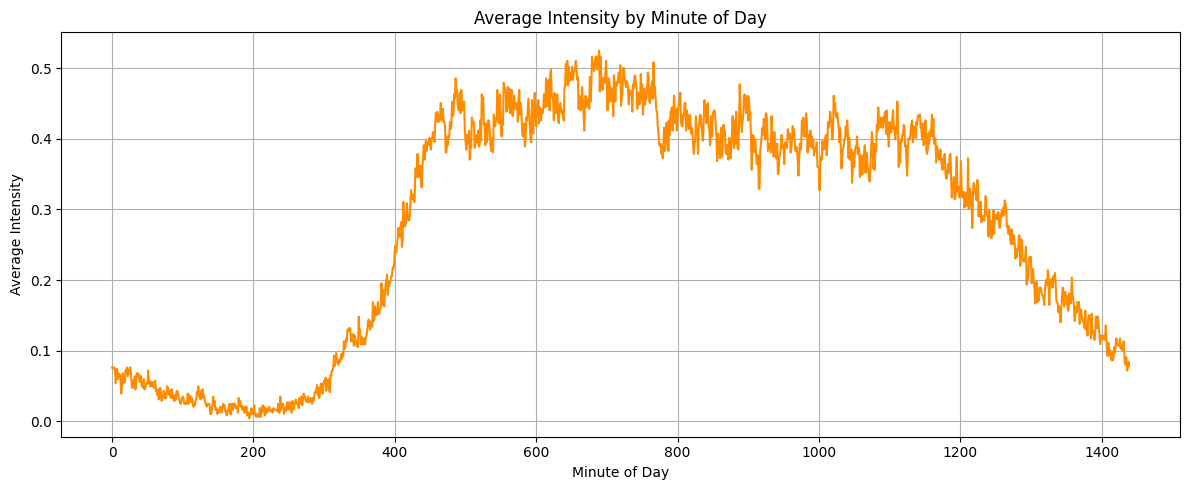

In [91]:
def plot_avg_minute_intensity(df_minute):
    """
    Plots average intensity per minute (0 to 1439) across all days.
    Assumes intensity_array length is 1440.
    """
    all_arrays = np.stack(df_minute['intensity_array'].values)  # shape: (n_days, 1440)
    avg_per_minute = all_arrays.mean(axis=0)

    minutes = np.arange(1440)

    plt.figure(figsize=(12, 5))
    plt.plot(minutes, avg_per_minute, color='darkorange')
    plt.title("Average Intensity by Minute of Day")
    plt.xlabel("Minute of Day")
    plt.ylabel("Average Intensity")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_avg_minute_intensity(df_minute)

In [59]:
def plot_avg_hour_intensity(df_hourly):
    """
    Plots average intensity per hour (0 to 23) across all data.
    Assumes intensity_array length is 24.
    """
    all_arrays = np.stack(df_hourly['intensity_array'].values)  # shape: (n_days, 24)
    avg_per_hour = all_arrays.mean(axis=0)

    hours = np.arange(24)

    plt.figure(figsize=(10, 5))
    plt.plot(hours, avg_per_hour, marker='o', color='darkorange')
    plt.title("Average Intensity by Hour of Day")
    plt.xlabel("Hour of Day")
    plt.ylabel("Average Intensity")
    plt.xticks(hours)
    plt.grid(True)
    plt.tight_layout()
    plt.show()



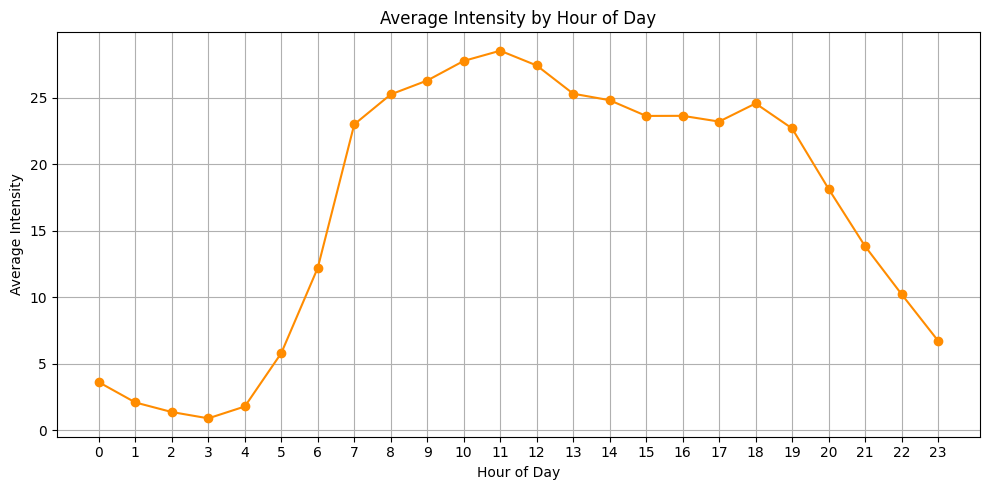

In [61]:
import matplotlib.pyplot as plt
plot_avg_hour_intensity(df_hourly)

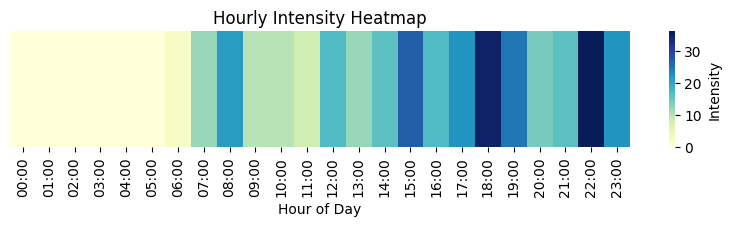

In [82]:
import seaborn as sns
def plot_single_day_hourly_heatmap(intensity_array, subject_id=None, day_label=None):
    """
    intensity_array: list or np.array of 24 values (1 day of hourly intensity)
    """
    arr = np.array(intensity_array).reshape(1, 24)  # 1 row of 24 hours

    plt.figure(figsize=(10, 1.5))
    sns.heatmap(arr, cmap="YlGnBu", cbar_kws={'label': 'Intensity'}, vmin=0)
    title = "Hourly Intensity Heatmap"
    if subject_id is not None and day_label is not None:
        title += f" - Subject {subject_id}, Day {day_label}"
    plt.title(title)
    plt.xlabel("Hour of Day")
    plt.yticks([])
    plt.xticks(ticks=np.arange(24)+0.5, labels=[f"{h:02d}:00" for h in range(24)], rotation=90)
    plt.show()


plot_single_day_hourly_heatmap(df_hourly.iloc[0]['intensity_array'])

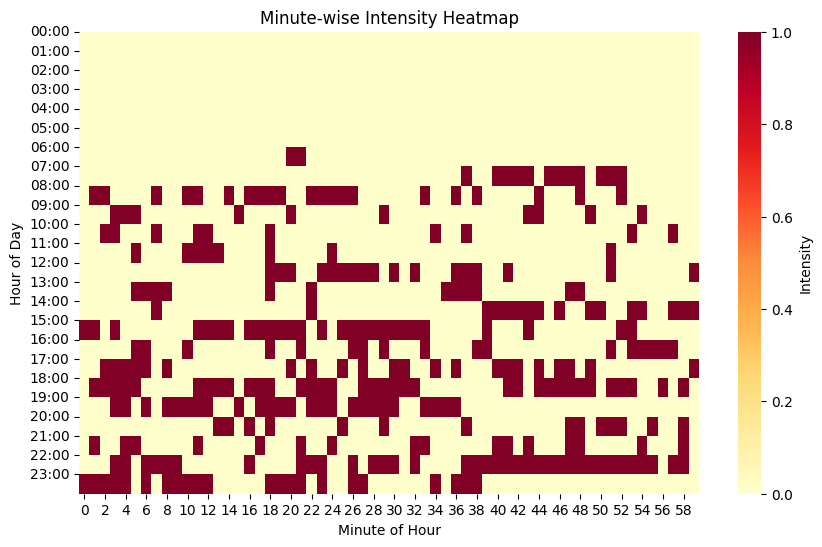

In [87]:
def plot_single_day_minute_heatmap(intensity_array, subject_id=None, day_label=None):
    """
    intensity_array: list or np.array of 1440 values (1 day of minute-wise intensity)
    """
    arr = np.array(intensity_array).reshape(24, 60)  # Reshape to 24 hours × 60 minutes

    plt.figure(figsize=(10, 6))
    sns.heatmap(arr, cmap="YlOrRd", cbar_kws={'label': 'Intensity'}, vmin=0)
    title = "Minute-wise Intensity Heatmap"
    if subject_id is not None and day_label is not None:
        title += f" - Subject {subject_id}, Day {day_label}"
    plt.title(title)
    plt.xlabel("Minute of Hour")
    plt.ylabel("Hour of Day")
    plt.yticks(ticks=np.arange(0, 24), labels=[f"{h:02d}:00" for h in range(24)], rotation=0)
    plt.show()



plot_single_day_minute_heatmap(df_minute.iloc[0]['intensity_array'])